<a href="https://colab.research.google.com/github/PridaLab/structure_index/blob/main/demos/structure_index_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Imports 
import os, sys
import random
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import matplotlib

In [ ]:
#run this cell if you haven't clone the repository
!git clone https://github.com/PridaLab/structure_index.git

In [ ]:
sys.path.insert(0,'/content/structure_index')
from structure_index import compute_structure_index, draw_graph


# 3D BALL TOY MODEL

## 1. Generate data
For this example, we are going to generate a data cloud sampled from a solid 3D ball with some gaussian noise. To do so, we will utilize the equations:

\begin{equation}
x(r, \theta, \phi) = r\cdot\sin(\theta)\cdot\cos(\phi) + \mathcal{N}(0,\sigma)
\end{equation}

\begin{equation}
y(r, \theta, \phi) = r\cdot\sin(\theta)\cdot\sin(\phi) + \mathcal{N}(0,\sigma)
\end{equation}

\begin{equation}
z(r, \theta) = r\cdot\cos(\theta) + \mathcal{N}(0,\sigma)
\end{equation}

where  $\theta\in[0,\pi]$, $\phi\in[0,2\pi]$. In this case, we will use the radius ($r$) as our feature.

[]

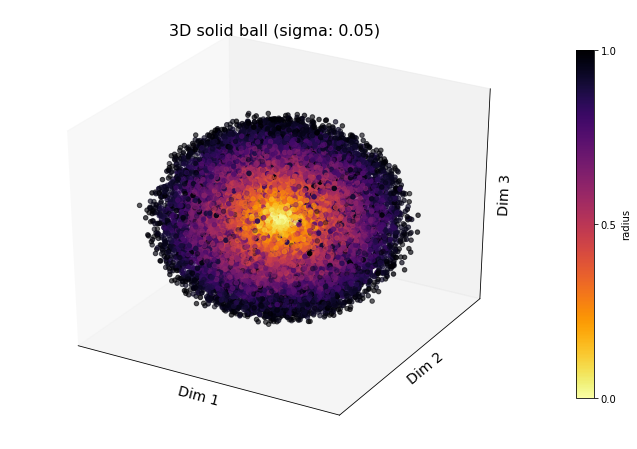

In [ ]:
#random sampling from 3D solid ball with gaussian noise
def sample_from_ball(rad, sigma):
    dim_sigma = np.sqrt((sigma**2)/3)
    r = random.uniform(0,rad)
    theta = random.uniform(0, np.pi-0.01)
    phi = random.uniform(0, 2*np.pi-0.01)
    x = r*np.sin(theta)*np.cos(phi) + random.gauss(0, dim_sigma)
    y = r*np.sin(theta)*np.sin(phi) + random.gauss(0, dim_sigma)
    z = r*np.cos(theta)+ random.gauss(0, dim_sigma)
    return (x,y,z), r

#generate data cloud by sampling 40,000 points
sigma = 0.05
npoints = 40000
emb = np.empty((npoints, 3))
feature = np.empty((npoints,))
for ii in range(npoints):
    emb[ii,:], feature[ii] = sample_from_ball(1,sigma)

real_angle = np.arctan2(emb[:,1],emb[:,0])
to_plot = np.invert((real_angle<=0)*(real_angle>=-np.pi/2)*(emb[:,2]>0))
#plot resulting generated data cloud
fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection = '3d')
b = ax.scatter(*emb[to_plot,:].T, c=feature[to_plot], s=20, cmap='inferno_r',vmin=0, vmax=1)
cbar = fig.colorbar(b,ax=ax,anchor=(0, 0.3), shrink=0.8, ticks=[0, 0.5, 1])
cbar.set_label('radius', rotation=90)
ax.set_xlabel('Dim 1', labelpad=-8, size=14)
ax.set_ylabel('Dim 2', labelpad=-8, size=14)
ax.set_zlabel('Dim 3', labelpad=-8, size=14)
ax.set_title(f'3D solid ball (sigma: {sigma})', size=16);
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

## 2. Compute Structure Index
The next step is to compute the structure index. This will allow us to quantify the amount of structure the distribution of the feature radius has over the 3D ball point cloud. Intuitively, given the way we have generated the data, this should be high, but not 1 as we have added some gaussian noise.

To do so, we will use the function

```
# SI, bin_label, overlap_mat, shuf_SI = compute_structure_index(data, feature)
```
where
```
    data: numpy 2d array of shape [n_samples,n_dimensions]
        Array containing the signal

    label: numpy 2d array of shape [n_samples,n_features]
        Array containing the labels of the data. It can either be a 
        column vector (scalar feature) or a 2D array (vectorial feature)
```
Moreover, we will specify the following optional parameters
```
    n_bins: integer (default: 10)
        number of bin-groups the label will be divided into (they will 
        become nodes on the graph). For vectorial features, if one wants 
        different number of bins for each entry then specify n_bins as a 
        list (i.e. [10,20,5]). Note that it will be ignored if 
        'discrete_label' is set to True.

    n_neighbors: int (default: 15)
        Number of neighbors used to compute the overlapping between 
        bin-groups. This parameter controls the tradeoff between local and 
        global structure.

    discrete_label: boolean (default: False)
        If the label is discrete, then one bin-group will be created for 
        each discrete value it takes. Note that if set to True, 'n_bins' 
        parameter will be ignored.
    
    num_shuffles: int (default: 100)
        Number of shuffles to be computed. Note it must fall within the 
        interval [0, np.inf).

    verbose: boolean (default: False)
        Boolean controling whether or not to print internal process..
```

In [ ]:
params = {
    'n_bins': 10,
    'n_neighbors': 15,
    'discrete_label': False,
    'num_shuffles': 10,
    'verbose': True,
}

SI,binLabel,overlapMat,sSI = compute_structure_index(emb,feature,**params)

Computing bin-groups...: Done


Computing overlap:   0%|          | 0/45 [00:00<?, ?it/s]

Computing structure index...: 0.90


Computing shuffling:   0%|          | 0/100 [00:00<?, ?it/s]

Shuffling 99th percentile: 0.00


## 3. Plot the results (overlap matrix and weighted directed graph)
To plot the weighted directed graph, the repository includes a function 'draw_graph', that works as follows:
```
draw_graph(overlap_mat, ax)
```
where
```
    overlap_mat: numpy 2d array of shape [n_bins, n_bins]
          Array containing the overlapping between each pair of bin-groups.

    ax: matplotlib pyplot axis object.
```
Moreover, we can define some optional parameters to tune the visuals
```
      node_cmap: pyplot colormap (default: plt.cm.tab10)
          colormap for mapping nodes.

      edge_cmap: pyplot colormap (default: plt.cm.Greys)
          colormap for mapping intensities of edges.

      node_cmap: pyplot colormap (default: plt.cm.tab10)
          pyplot colormap used to color the nodes of the graph.

      node_size: scalar or array  (default: 1000)
          size of nodes. If an array is specified it must be the same length 
          as nodelist.

      scale_edges: scalar (default: 5)
          number used to scale the width of the edges.

      edge_vmin: scalar (default: 0)
          minimum  for edge colormap scaling

      edge_vmax: scalar (default: 0.5)
          maximum for edge colormap scaling

      node_names: scalar (default: 0)
          list containing name of nodes. If numerical, then nodes colormap 
          will be scale according to it.


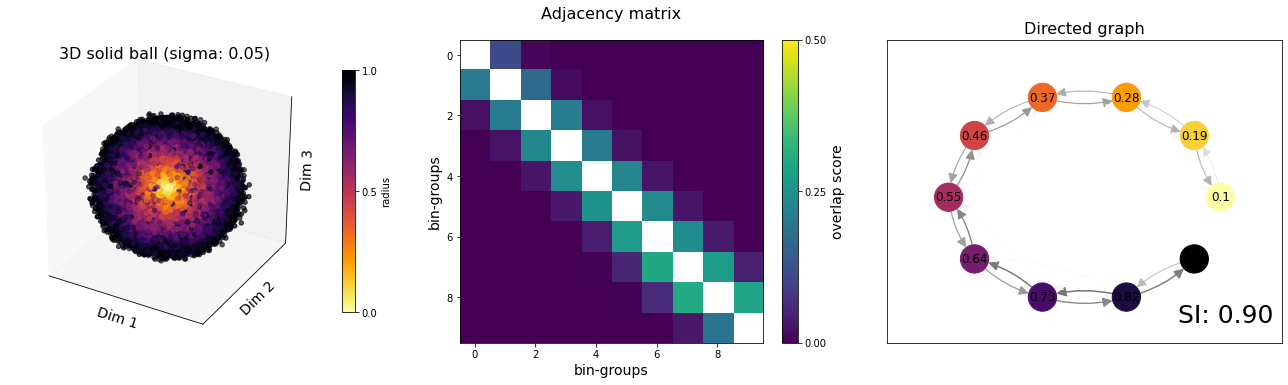

In [ ]:
f, ax = plt.subplots(1, 3, figsize=(18,5))

#plot 3D scatter
at = plt.subplot(1,3,1,projection = '3d')
b = at.scatter(*emb.T, c = feature, cmap = 'inferno_r',vmin= 0, vmax = 1)
cbar = fig.colorbar(b,ax=at,anchor=(0, 0.3), shrink=0.8, ticks=[0, 0.5, 1])
cbar.set_label('radius', rotation=90)
at.set_title(f'3D solid ball (sigma: {sigma})', size=16);
at.set_xlabel('Dim 1', labelpad=-8, size=14)
at.set_ylabel('Dim 2', labelpad=-8, size=14)
at.set_zlabel('Dim 3', labelpad=-8, size=14)
at.set_xticks([])
at.set_yticks([])
at.set_zticks([])

#plot adjacency matrix
b = ax[1].matshow(overlapMat, vmin = 0, vmax = 0.5, cmap = plt.cm.viridis)
ax[1].xaxis.set_ticks_position('bottom')
cbar = fig.colorbar(b,ax=ax[1],anchor=(0, 0.2), shrink=1, ticks=[0,0.25,0.5])
cbar.set_label('overlap score', rotation=90, fontsize = 14)
ax[1].set_title('Adjacency matrix', size=16);
ax[1].set_xlabel('bin-groups', size=14)
ax[1].set_ylabel('bin-groups', size=14)

#plot weighted directed graph
draw_graph(overlapMat, ax[2],node_cmap=plt.cm.inferno_r,edge_cmap=plt.cm.Greys, 
                                  node_names = np.round(binLabel[1][:,0,1],2));
ax[2].set_xlim(1.2*np.array(ax[2].get_xlim()));
ax[2].set_ylim(1.2*np.array(ax[2].get_ylim()));
ax[2].set_title('Directed graph', size=16);
ax[2].text(0.98, 0.05, f"SI: {SI:.2f}", horizontalalignment='right',
     verticalalignment='bottom', transform=ax[2].transAxes,fontsize=25)
plt.tight_layout()